# Serbian Legal Named Entity Recognition (NER) Pipeline - BERTić + CRF 5-Fold Cross-Validation

This notebook implements 5-fold cross-validation for the Serbian Legal NER pipeline using BERTić with a CRF layer.

## Key Features
- **5-Fold Cross-Validation**: Robust evaluation across different data splits
- **BERTić + CRF Architecture**: Adds CRF layer on top of fine-tuned BERTić for sequence constraints
- **Sliding Window Tokenization**: Handles long sequences without truncation
- **Comprehensive Metrics**: Precision, recall, F1-score, and accuracy tracking
- **Statistical Analysis**: Mean and standard deviation across folds

## Architecture
This notebook builds on the base BERTić 5-fold CV pipeline by adding a CRF layer on top of the fine-tuned model.
The CRF layer enforces valid BIO sequence constraints for better entity boundary detection.

## Entity Types
- **COURT**: Court institutions
- **DECISION_DATE**: Dates of legal decisions
- **CASE_NUMBER**: Case identifiers
- **CRIMINAL_ACT**: Criminal acts/charges
- **PROSECUTOR**: Prosecutor entities
- **DEFENDANT**: Defendant entities
- **JUDGE**: Judge names
- **REGISTRAR**: Court registrar
- **SANCTION_TYPE**: Type of sanction
- **SANCTION_VALUE**: Value/duration of sanction
- **PROVISION_MATERIAL**: Material law provisions
- **PROVISION_PROCEDURAL**: Procedural law provisions
- **VERDICT**: Verdict information
- **PROCEDURE_COSTS**: Legal procedure costs

## 1. Environment Setup and Dependencies

In [1]:
# Install required packages including pytorch-crf for CRF layer
!pip install transformers torch datasets tokenizers scikit-learn seqeval pandas numpy matplotlib seaborn tqdm pytorch-crf

In [2]:
# Import shared modules
import sys
import os

sys.path.append('/shared/')


import importlib
import shared
import shared.model_utils
import shared.data_processing
import shared.dataset
import shared.evaluation
import shared.config
importlib.reload(shared.config)
importlib.reload(shared.data_processing)
importlib.reload(shared.dataset)
importlib.reload(shared.model_utils)
importlib.reload(shared.evaluation)
importlib.reload(shared)

# Import from shared modules
from shared import (
    # Configuration
    ENTITY_TYPES, BIO_LABELS,
    get_default_model_config, setup_environment,

    # Data processing
    LabelStudioToBIOConverter, load_labelstudio_data,
    analyze_labelstudio_data, validate_bio_examples,

    # Dataset
    NERDataset, tokenize_and_align_labels_with_sliding_window,
    create_huggingface_datasets,

    # Model utilities
    load_model_and_tokenizer, create_training_arguments, create_trainer,
    detailed_evaluation, setup_device_and_seed,
    PerClassMetricsCallback,

    # Comprehensive tracking
    analyze_entity_distribution_per_fold,
    generate_detailed_classification_report,
    # Aggregate functions
    create_aggregate_report_across_folds
)

# Standard imports
import warnings
warnings.filterwarnings('ignore')
import numpy as np
from sklearn.model_selection import KFold
import torch
import torch.nn as nn
from transformers import DataCollatorForTokenClassification, AutoTokenizer, Trainer
from torchcrf import CRF

# Setup device and random seed
device = setup_device_and_seed(42)

2025-10-03 21:25:10.304336: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-10-03 21:25:10.304412: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-10-03 21:25:10.305987: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-10-03 21:25:10.314963: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-03 21:25:11.508276: W tensorflow/compiler/tf2

🔧 Setup complete:
  PyTorch version: 2.1.1+cu121
  CUDA available: True
  CUDA device: Quadro RTX 5000
  Device: cuda
  Random seed: 42


## 2. Configuration and Environment Setup

In [3]:
# Setup environment and paths
env_setup = setup_environment(use_local=False, create_dirs=False)
paths = env_setup['paths']

# Model configuration
MODEL_NAME = "classla/bcms-bertic"
model_config = get_default_model_config()

# Output directory
OUTPUT_DIR = f"{paths['models_dir']}/bertic_crf_5fold_cv"
os.makedirs(OUTPUT_DIR, exist_ok=True)

print(f"🔧 Configuration:")
print(f"  Model: {MODEL_NAME}")
print(f"  Architecture: BERTić + CRF")
print(f"  Output directory: {OUTPUT_DIR}")
print(f"  Entity types: {len(ENTITY_TYPES)}")
print(f"  BIO labels: {len(BIO_LABELS)}")

🔧 Environment setup (cloud):
  ✅ labelstudio_json: /datasets/annotations/annotations.json
  ✅ judgments_dir: /datasets/judgments
  ✅ labelstudio_files_dir: /datasets/judgments
  ❌ mlm_data_dir: /datasets/dapt-mlm
  ✅ models_dir: /storage/models
  ✅ logs_dir: /storage/logs
  ✅ results_dir: /storage/results
🔧 Configuration:
  Model: classla/bcms-bertic
  Output directory: /storage/models/bertic_base_5fold_cv
  Entity types: 16
  BIO labels: 33


## 3. Data Loading and Analysis

In [4]:
# Load LabelStudio data
labelstudio_data = load_labelstudio_data(paths['labelstudio_json'])

# Analyze the data
if labelstudio_data:
    analysis = analyze_labelstudio_data(labelstudio_data)
else:
    print("❌ No data loaded. Please check your paths.")
    exit()

✅ Loaded 225 annotated documents from /datasets/annotations/annotations.json
📊 Analysis Results:
Total documents: 225
Total annotations: 225
Unique entity types: 14

Entity distribution:
  DEFENDANT: 1240
  PROVISION_MATERIAL: 1177
  CRIMINAL_ACT: 792
  PROVISION_PROCEDURAL: 686
  REGISTRAR: 460
  COURT: 458
  JUDGE: 451
  PROSECUTOR: 395
  DECISION_DATE: 359
  SANCTION_TYPE: 248
  SANCTION_VALUE: 241
  VERDICT: 238
  PROCEDURE_COSTS: 231
  CASE_NUMBER: 225


## 4. Data Preprocessing and BIO Conversion

In [5]:
# Convert LabelStudio data to BIO format
converter = LabelStudioToBIOConverter(
    judgments_dir=paths['judgments_dir'],
    labelstudio_files_dir=paths.get('labelstudio_files_dir')
)

bio_examples = converter.convert_to_bio(labelstudio_data)
print(f"✅ Converted {len(bio_examples)} examples to BIO format")

# Validate BIO examples
valid_examples, stats = validate_bio_examples(bio_examples)
print(f"📊 Validation complete: {stats['valid_examples']} valid examples")

✅ Converted 225 examples to BIO format
📊 BIO Validation Results:
Total examples: 225
Valid examples: 225
Invalid examples: 0
Empty examples: 0
📊 Validation complete: 225 valid examples


## 5. Dataset Preparation

In [6]:
# Create NER dataset
ner_dataset = NERDataset(valid_examples)
prepared_examples = ner_dataset.prepare_for_training()

print(f"📊 Dataset statistics:")
print(f"  Number of unique labels: {ner_dataset.get_num_labels()}")
print(f"  Prepared examples: {len(prepared_examples)}")

# Get label statistics
label_stats = ner_dataset.get_label_statistics()
print(f"  Total tokens: {label_stats['total_tokens']}")
print(f"  Entity types found: {len(label_stats['entity_counts'])}")

📊 Dataset statistics:
  Number of unique labels: 29
  Prepared examples: 225
  Total tokens: 232475
  Entity types found: 14


## 6. BERTić-CRF Model Definition

In [ ]:
class BerticCRF(nn.Module):
    """
    BERTić model with CRF layer for token classification.
    
    This model adds a CRF layer on top of a fine-tuned BERTić model.
    The BERTić model is first fine-tuned normally, then the CRF layer
    is added to enforce valid BIO sequence constraints.
    """
    
    def __init__(self, bertic_model, num_labels):
        """
        Args:
            bertic_model: Pre-trained/fine-tuned BERTić model
            num_labels: Number of NER labels
        """
        super().__init__()
        self.num_labels = num_labels
        self.bertic = bertic_model
        self.crf = CRF(num_labels, batch_first=True)
        
        # Store config from the base model
        self.config = bertic_model.config
    
    def forward(self, input_ids, attention_mask=None, labels=None, **kwargs):
        # Get BERTić outputs (logits)
        outputs = self.bertic(
            input_ids=input_ids,
            attention_mask=attention_mask,
            return_dict=True
        )
        
        logits = outputs.logits
        
        loss = None
        if labels is not None:
            # CRITICAL FIX: Create mask based on valid labels, NOT attention_mask
            # -100 indicates special tokens (CLS, SEP, PAD) that should be ignored
            mask = (labels != -100)
            
            # Replace -100 with 0 (O tag) for CRF compatibility
            # These positions will be masked out, so the value doesn't affect training
            labels_for_crf = labels.clone()
            labels_for_crf[~mask] = 0
            
            # Compute CRF loss with proper masking
            # The mask ensures CRF only learns from actual tokens, not special tokens
            log_likelihood = self.crf(logits, labels_for_crf, mask=mask, reduction='mean')
            loss = -log_likelihood
        
        return {
            'loss': loss,
            'logits': logits
        }
    
    def decode(self, input_ids, attention_mask=None):
        """Decode using CRF Viterbi algorithm"""
        with torch.no_grad():
            outputs = self.bertic(
                input_ids=input_ids,
                attention_mask=attention_mask,
                return_dict=True
            )
            logits = outputs.logits
            
            # For decoding, we use attention_mask (not labels) since we don't have labels
            # This masks out padding tokens during inference
            if attention_mask is not None:
                mask = attention_mask.bool()
            else:
                mask = torch.ones(input_ids.shape[:2], dtype=torch.bool, device=input_ids.device)
            
            # CRF decode returns list of lists using Viterbi algorithm
            predictions = self.crf.decode(logits, mask=mask)
            return predictions

print("✅ BERTić-CRF model class defined successfully!")
print("")
print("🔧 Key CRF Fixes Applied:")
print("  1. Mask based on (labels != -100) instead of attention_mask")
print("  2. This ensures CRF only learns from actual tokens, not special tokens")
print("  3. CRF will now properly learn BIO sequence constraints")

## 7. K-Fold Cross-Validation Setup

In [7]:
# Set up 5-fold cross-validation
N_FOLDS = 5
kfold = KFold(n_splits=N_FOLDS, shuffle=True, random_state=42)

# Convert to numpy array for easier indexing
examples_array = np.array(prepared_examples, dtype=object)

print(f"Setting up {N_FOLDS}-fold cross-validation")
print(f"Total examples: {len(prepared_examples)}")
print(f"Examples per fold (approx): {len(prepared_examples) // N_FOLDS}")

# Load tokenizer (will be used across all folds)
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
print(f"\nLoaded tokenizer for {MODEL_NAME}")
print(f"Tokenizer vocab size: {tokenizer.vocab_size}")

# Store results from all folds
fold_results = []

Setting up 5-fold cross-validation
Total examples: 225
Examples per fold (approx): 45

Loaded tokenizer for classla/bcms-bertic
Tokenizer vocab size: 32000


## 8. K-Fold Cross-Validation Helper Functions

In [8]:
# ============================================================================
# K-FOLD CROSS-VALIDATION HELPER FUNCTIONS
# ============================================================================

def prepare_fold_data(train_examples, val_examples, tokenizer, ner_dataset):
    """
    Prepare training and validation datasets for a specific fold.

    Args:
        train_examples: Training examples for this fold
        val_examples: Validation examples for this fold
        tokenizer: Tokenizer instance
        ner_dataset: NER dataset instance

    Returns:
        tuple: (train_dataset, val_dataset, data_collator)
    """
    # Tokenize datasets with sliding window
    train_tokenized = tokenize_and_align_labels_with_sliding_window(
        train_examples, tokenizer, ner_dataset.label_to_id,
        max_length=model_config['max_length'], stride=model_config['stride']
    )

    val_tokenized = tokenize_and_align_labels_with_sliding_window(
        val_examples, tokenizer, ner_dataset.label_to_id,
        max_length=model_config['max_length'], stride=model_config['stride']
    )

    # Create HuggingFace datasets
    train_dataset, val_dataset, _ = create_huggingface_datasets(
        train_tokenized, val_tokenized, val_tokenized  # Using val as placeholder for test
    )

    # Data collator
    data_collator = DataCollatorForTokenClassification(
        tokenizer=tokenizer,
        padding=True,
        return_tensors="pt"
    )

    return train_dataset, val_dataset, data_collator

print("✅ K-fold helper functions defined successfully!")

✅ K-fold helper functions defined successfully!


In [9]:
def create_model_and_trainer(fold_num, train_dataset, val_dataset, data_collator, tokenizer, ner_dataset, device):
    """
    Create BERTić-CRF model and trainer for a specific fold.
    
    This function:
    1. Loads a fresh BERTić model (which will be fine-tuned)
    2. Wraps it with a CRF layer
    3. Creates a trainer for the combined model

    Args:
        fold_num: Current fold number
        train_dataset: Training dataset for this fold
        val_dataset: Validation dataset for this fold
        data_collator: Data collator
        tokenizer: Tokenizer instance
        ner_dataset: NER dataset instance
        device: Device to use (cuda/cpu)

    Returns:
        tuple: (model, trainer, metrics_callback, fold_output_dir)
    """
    # Create fold-specific output directory
    fold_output_dir = f"{OUTPUT_DIR}/fold_{fold_num}"
    import os
    os.makedirs(fold_output_dir, exist_ok=True)

    # Load fresh BERTić model for this fold (this will be fine-tuned)
    bertic_model, _ = load_model_and_tokenizer(
        MODEL_NAME,
        ner_dataset.get_num_labels(),
        ner_dataset.id_to_label,
        ner_dataset.label_to_id
    )
    
    # Wrap BERTić model with CRF layer
    model = BerticCRF(bertic_model, ner_dataset.get_num_labels())

    # Move model to device
    model.to(device)
    
    print(f"🔧 BERTić-CRF model created for fold {fold_num}")
    print(f"📊 Model parameters: {sum(p.numel() for p in model.parameters()):,}")

    # Create training arguments for this fold
    training_args = create_training_arguments(
        output_dir=fold_output_dir,
        num_epochs=model_config['num_epochs'],
        batch_size=model_config['batch_size'],
        learning_rate=model_config['learning_rate'],
        warmup_steps=500,
        weight_decay=0.01,
        logging_steps=50,
        eval_steps=100,
        save_steps=500,
        early_stopping_patience=3
    )

    # Create metrics callback for comprehensive tracking
    metrics_callback = PerClassMetricsCallback(id_to_label=ner_dataset.id_to_label)

    # Custom compute_metrics for CRF
    def compute_metrics_crf(eval_pred):
        # Placeholder - actual metrics computed in detailed_evaluation
        return {"f1": 0.0}
    
    # Create trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        data_collator=data_collator,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics_crf,
        callbacks=[metrics_callback]
    )

    print(f"Trainer initialized for fold {fold_num} with comprehensive metrics tracking")
    return model, trainer, metrics_callback, fold_output_dir

print("✅ BERTić-CRF model and trainer creation function defined successfully!")

✅ Model and trainer creation function defined successfully!


In [10]:
def train_and_evaluate_fold(fold_num, trainer, val_dataset, ner_dataset):
    """
    Train and evaluate a BERTić-CRF model for a specific fold.

    Args:
        fold_num: Current fold number
        trainer: Trainer instance
        val_dataset: Validation dataset for this fold
        ner_dataset: NER dataset instance

    Returns:
        dict: Fold results including metrics
    """
    print(f"\n🏋️  Training BERTić-CRF fold {fold_num}...")

    # Train the model
    trainer.train()

    print(f"💾 Saving BERTić-CRF model for fold {fold_num}...")
    trainer.save_model()

    # Evaluate on validation set using CRF decoding
    print(f"📊 Evaluating BERTić-CRF fold {fold_num}...")
    
    model = trainer.model
    model.eval()
    device = trainer.args.device
    
    all_predictions = []
    all_labels = []
    
    with torch.no_grad():
        for batch in trainer.get_eval_dataloader():
            batch = {k: v.to(device) for k, v in batch.items()}
            
            # Get CRF predictions
            predictions = model.decode(
                input_ids=batch['input_ids'],
                attention_mask=batch['attention_mask']
            )
            
            labels = batch['labels']
            
            # Process predictions and labels
            for pred_seq, label_seq, attention_seq in zip(predictions, labels, batch['attention_mask']):
                # Filter based on attention mask and ignore -100 labels
                valid_length = attention_seq.sum().item()
                pred_seq = pred_seq[:valid_length]
                label_seq = label_seq[:valid_length]
                
                # Filter out -100 labels
                valid_indices = label_seq != -100
                if valid_indices.any():
                    pred_filtered = [pred_seq[i] for i in range(len(pred_seq)) if valid_indices[i]]
                    label_filtered = [label_seq[i].item() for i in range(len(label_seq)) if valid_indices[i]]
                    
                    all_predictions.extend(pred_filtered)
                    all_labels.extend(label_filtered)
    
    # Convert to label names
    pred_labels = [ner_dataset.id_to_label[pred] for pred in all_predictions]
    true_labels = [ner_dataset.id_to_label[label] for label in all_labels]
    
    # Calculate metrics using seqeval
    from seqeval.metrics import precision_score, recall_score, f1_score, accuracy_score
    
    # Convert to sequence format for seqeval
    pred_sequences = [pred_labels]
    true_sequences = [true_labels]
    
    precision = precision_score(true_sequences, pred_sequences)
    recall = recall_score(true_sequences, pred_sequences)
    f1 = f1_score(true_sequences, pred_sequences)
    accuracy = accuracy_score(true_sequences, pred_sequences)
    
    print(f"\n📊 Fold {fold_num} Validation Set Results:")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1-score: {f1:.4f}")
    print(f"  Accuracy: {accuracy:.4f}")

    # Extract metrics
    fold_result = {
        'fold': fold_num,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'accuracy': accuracy,
        'true_predictions': pred_labels,
        'true_labels': true_labels
    }

    print(f"\nBERTić-CRF Fold {fold_num} completed successfully!")
    return fold_result

print("✅ BERTić-CRF training and evaluation helper function defined successfully!")

✅ Training and evaluation helper function defined successfully!


## 9. K-Fold Cross-Validation Training Loop

In [11]:
# Check device availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Main K-Fold Cross-Validation Loop
print(f"\n{'='*80}")
print(f"STARTING {N_FOLDS}-FOLD CROSS-VALIDATION")
print(f"{'='*80}")
print(f"Total examples: {len(examples_array)}")
print(f"Model: {MODEL_NAME}")
print(f"Device: {device}")

# Execute K-Fold training
for fold_num, (train_idx, val_idx) in enumerate(kfold.split(examples_array), 1):
    print(f"\n{'='*80}")
    print(f"FOLD {fold_num}/{N_FOLDS}")
    print(f"{'='*80}")
    print(f"Train indices: {len(train_idx)}, Val indices: {len(val_idx)}")

    # Get fold data
    train_examples = examples_array[train_idx].tolist()
    val_examples = examples_array[val_idx].tolist()

    print(f"Training examples: {len(train_examples)}")
    print(f"Validation examples: {len(val_examples)}")

    # Analyze entity distributions for this fold
    print(f"\n📊 Analyzing entity distributions...")
    train_dist = analyze_entity_distribution_per_fold(train_examples, f"Fold {fold_num} - Training")
    val_dist = analyze_entity_distribution_per_fold(val_examples, f"Fold {fold_num} - Validation")

    # Prepare data for this fold
    print(f"\n🔤 Preparing data for fold {fold_num}...")
    train_dataset, val_dataset, data_collator = prepare_fold_data(
        train_examples, val_examples, tokenizer, ner_dataset
    )

    print(f"📦 Fold {fold_num} datasets:")
    print(f"  Training: {len(train_dataset)} examples")
    print(f"  Validation: {len(val_dataset)} examples")

    # Create model and trainer for this fold
    print(f"\n🤖 Creating model and trainer for fold {fold_num}...")
    model, trainer, metrics_callback, fold_output_dir = create_model_and_trainer(
        fold_num, train_dataset, val_dataset, data_collator, tokenizer, ner_dataset, device
    )

    # Train and evaluate this fold
    fold_result = train_and_evaluate_fold(fold_num, trainer, val_dataset, ner_dataset)
    
    # Get predictions and labels for aggregation
    print(f"\n📊 Getting predictions for fold {fold_num}...")
    predictions, labels, _ = trainer.predict(val_dataset)
    predictions = np.argmax(predictions, axis=2)
    
    # Convert to label names
    true_labels = [[ner_dataset.id_to_label[l] for l in label if l != -100] for label in labels]
    pred_labels = [[ner_dataset.id_to_label[p] for (p, l) in zip(prediction, label) if l != -100]
                   for prediction, label in zip(predictions, labels)]
    
    # Generate per-class metrics and confusion matrix for this fold
    from sklearn.metrics import confusion_matrix
    flat_true = [label for seq in true_labels for label in seq]
    flat_pred = [label for seq in pred_labels for label in seq]
    all_labels = sorted(list(set(flat_true + flat_pred)))
    cm = confusion_matrix(flat_true, flat_pred, labels=all_labels)
    
    # Generate classification report for this fold
    per_class_metrics = generate_detailed_classification_report(
        true_labels, pred_labels, fold_output_dir, fold_num, "Validation"
    )
    
    # Store comprehensive data for aggregation
    fold_result['distributions'] = {'train': train_dist, 'val': val_dist}
    fold_result['per_class_metrics'] = per_class_metrics
    fold_result['confusion_matrix'] = cm
    fold_result['labels'] = all_labels
    fold_result['training_history'] = metrics_callback.get_training_history()
    fold_results.append(fold_result)

    # Clean up to free memory
    del model, trainer, train_dataset, val_dataset, metrics_callback
    torch.cuda.empty_cache() if torch.cuda.is_available() else None

    print(f"\n✅ Fold {fold_num} completed!")
    print(f"   Precision: {fold_result['precision']:.4f}")
    print(f"   Recall: {fold_result['recall']:.4f}")
    print(f"   F1-Score: {fold_result['f1']:.4f}")
    print(f"   Accuracy: {fold_result['accuracy']:.4f}")

print(f"\n{'='*80}")
print(f"K-FOLD CROSS-VALIDATION COMPLETED!")
print(f"{'='*80}")

Using device: cuda

STARTING 5-FOLD CROSS-VALIDATION - BERTić + CRF
Total examples: 225
Model: classla/bcms-bertic + CRF
Device: cuda

BERTić-CRF FOLD 1/5
Train indices: 180, Val indices: 45
Training examples: 180
Validation examples: 45

📊 Analyzing entity distributions...

📊 Entity Distribution - Fold 1 - Training
Entity Type                         Count      Percentage
------------------------------------------------------------
PROVISION_MATERIAL                   7320          35.29%
PROVISION_PROCEDURAL                 3210          15.48%
CRIMINAL_ACT                         2252          10.86%
COURT                                1641           7.91%
DEFENDANT                            1445           6.97%
SANCTION_VALUE                        956           4.61%
JUDGE                                 734           3.54%
REGISTRAR                             731           3.52%
VERDICT                               573           2.76%
PROSECUTOR                            510

Some weights of ElectraForTokenClassification were not initialized from the model checkpoint at classla/bcms-bertic and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Loaded model (parameters: 110,049,053)
🖥️  Device: cuda
⚙️  Training configuration:
  Epochs: 8
  Batch size: 8
  Learning rate: 3e-05
  Warmup steps: 500
  Weight decay: 0.01
  Early stopping patience: 3
🏋️  Created trainer with early stopping (patience: 3)
📊 Additional callbacks: PerClassMetricsCallback
📊 Training dataset size: 1845
📊 Validation dataset size: 500
Trainer initialized for fold 1 with comprehensive metrics tracking

🏋️  Training fold 1...


wandb: Currently logged in as: pericapero1 (pericapero1-faculty-of-). Use `wandb login --relogin` to force relogin


You're using a ElectraTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
100,1.913300,0.731893,0.000000,0.000000,0.000000,0.896599
200,0.345200,0.305802,0.468966,0.187094,0.267477,0.929566
300,0.191800,0.196542,0.318564,0.359680,0.337876,0.959968
400,0.141100,0.139997,0.545835,0.717859,0.620138,0.972723
500,0.080600,0.101585,0.676490,0.757879,0.714876,0.980343
600,0.060200,0.084291,0.743401,0.810155,0.775344,0.983438
700,0.051400,0.076337,0.794275,0.818909,0.806404,0.984924
800,0.040200,0.072351,0.812302,0.835668,0.823820,0.985302
900,0.038900,0.074791,0.798956,0.841921,0.819876,0.984723
1000,0.031200,0.070873,0.780616,0.856178,0.816653,0.984900


💾 Saving model for fold 1...
📊 Evaluating fold 1...



📊 Fold 1 Validation Set Results:
  Precision: 0.8098
  Recall: 0.8532
  F1-score: 0.8309
  Accuracy: 0.9851

Fold 1 Validation Set - Detailed Classification Report:
                        precision    recall  f1-score   support

         B-CASE_NUMBER       0.71      0.98      0.82        45
               B-COURT       0.89      0.96      0.92       122
        B-CRIMINAL_ACT       0.96      0.95      0.96       519
       B-DECISION_DATE       0.94      0.96      0.95       114
           B-DEFENDANT       0.73      0.70      0.72       811
               B-JUDGE       0.93      0.93      0.93       107
     B-PROCEDURE_COSTS       1.00      0.98      0.99       141
          B-PROSECUTOR       0.40      0.61      0.48       241
  B-PROVISION_MATERIAL       0.96      0.96      0.96       819
B-PROVISION_PROCEDURAL       0.93      0.95      0.94       381
           B-REGISTRAR       0.88      0.97      0.92       113
       B-SANCTION_TYPE       0.90      0.90      0.90       197
 


Validation - Fold 1 Set - Detailed Classification Report:
                        precision    recall  f1-score   support

         B-CASE_NUMBER     0.7097    0.9778    0.8224        45
               B-COURT     0.8931    0.9590    0.9249       122
        B-CRIMINAL_ACT     0.9630    0.9538    0.9584       519
       B-DECISION_DATE     0.9402    0.9649    0.9524       114
           B-DEFENDANT     0.7280    0.7028    0.7152       811
               B-JUDGE     0.9340    0.9252    0.9296       107
     B-PROCEDURE_COSTS     1.0000    0.9787    0.9892       141
          B-PROSECUTOR     0.4011    0.6058    0.4826       241
  B-PROVISION_MATERIAL     0.9599    0.9634    0.9616       819
B-PROVISION_PROCEDURAL     0.9330    0.9501    0.9415       381
           B-REGISTRAR     0.8800    0.9735    0.9244       113
       B-SANCTION_TYPE     0.8990    0.9036    0.9013       197
      B-SANCTION_VALUE     0.8939    0.8421    0.8672       190
             B-VERDICT     0.9143    0.9302 

Some weights of ElectraForTokenClassification were not initialized from the model checkpoint at classla/bcms-bertic and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Loaded model (parameters: 110,049,053)
🖥️  Device: cuda
⚙️  Training configuration:
  Epochs: 8
  Batch size: 8
  Learning rate: 3e-05
  Warmup steps: 500
  Weight decay: 0.01
  Early stopping patience: 3
🏋️  Created trainer with early stopping (patience: 3)
📊 Additional callbacks: PerClassMetricsCallback
📊 Training dataset size: 1900
📊 Validation dataset size: 445
Trainer initialized for fold 2 with comprehensive metrics tracking

🏋️  Training fold 2...


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
100,2.216700,0.808005,0.000000,0.000000,0.000000,0.899211
200,0.445300,0.349281,0.233593,0.180258,0.203488,0.926227
300,0.248800,0.204510,0.399940,0.379685,0.389549,0.955227
400,0.152000,0.130893,0.657427,0.698999,0.677576,0.974363
500,0.101200,0.103226,0.693275,0.772818,0.730889,0.980049
600,0.069700,0.084273,0.700073,0.819456,0.755075,0.982415
700,0.058500,0.078113,0.755942,0.846352,0.798596,0.983729
800,0.044100,0.067378,0.812046,0.864092,0.837261,0.987221
900,0.043700,0.066376,0.819172,0.882690,0.849745,0.987084
1000,0.035600,0.064492,0.851040,0.866381,0.858642,0.987567


💾 Saving model for fold 2...
📊 Evaluating fold 2...



📊 Fold 2 Validation Set Results:
  Precision: 0.8745
  Recall: 0.8996
  F1-score: 0.8869
  Accuracy: 0.9889

Fold 2 Validation Set - Detailed Classification Report:
                        precision    recall  f1-score   support

         B-CASE_NUMBER       0.79      0.91      0.85        45
               B-COURT       0.94      0.97      0.96       117
        B-CRIMINAL_ACT       0.95      0.96      0.95       497
       B-DECISION_DATE       0.90      0.90      0.90       118
           B-DEFENDANT       0.85      0.80      0.82       652
               B-JUDGE       1.00      0.94      0.97       107
     B-PROCEDURE_COSTS       0.79      0.93      0.85       100
          B-PROSECUTOR       0.68      0.73      0.71       199
  B-PROVISION_MATERIAL       0.95      0.97      0.96       733
B-PROVISION_PROCEDURAL       0.94      0.96      0.95       403
           B-REGISTRAR       0.96      0.99      0.98       109
       B-SANCTION_TYPE       0.93      0.93      0.93       129
 


Validation - Fold 2 Set - Detailed Classification Report:
                        precision    recall  f1-score   support

         B-CASE_NUMBER     0.7885    0.9111    0.8454        45
               B-COURT     0.9421    0.9744    0.9580       117
        B-CRIMINAL_ACT     0.9501    0.9577    0.9539       497
       B-DECISION_DATE     0.8983    0.8983    0.8983       118
           B-DEFENDANT     0.8513    0.7991    0.8244       652
               B-JUDGE     1.0000    0.9439    0.9712       107
     B-PROCEDURE_COSTS     0.7881    0.9300    0.8532       100
          B-PROSECUTOR     0.6840    0.7286    0.7056       199
  B-PROVISION_MATERIAL     0.9454    0.9686    0.9569       733
B-PROVISION_PROCEDURAL     0.9436    0.9553    0.9494       403
           B-REGISTRAR     0.9643    0.9908    0.9774       109
       B-SANCTION_TYPE     0.9302    0.9302    0.9302       129
      B-SANCTION_VALUE     0.8678    0.8268    0.8468       127
             B-VERDICT     0.9720    0.9858 

Some weights of ElectraForTokenClassification were not initialized from the model checkpoint at classla/bcms-bertic and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Loaded model (parameters: 110,049,053)
🖥️  Device: cuda
⚙️  Training configuration:
  Epochs: 8
  Batch size: 8
  Learning rate: 3e-05
  Warmup steps: 500
  Weight decay: 0.01
  Early stopping patience: 3
🏋️  Created trainer with early stopping (patience: 3)
📊 Additional callbacks: PerClassMetricsCallback
📊 Training dataset size: 1913
📊 Validation dataset size: 432
Trainer initialized for fold 3 with comprehensive metrics tracking

🏋️  Training fold 3...


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
100,2.152600,0.822967,0.000000,0.000000,0.000000,0.893299
200,0.360900,0.330446,0.354893,0.184990,0.243207,0.928150
300,0.213100,0.205608,0.403959,0.442685,0.422437,0.957452
400,0.141900,0.140573,0.574691,0.627089,0.599748,0.971344
500,0.096700,0.105113,0.641846,0.770742,0.700413,0.979252
600,0.062300,0.097335,0.694081,0.838757,0.759591,0.982056
700,0.060900,0.075039,0.765257,0.885957,0.821196,0.986565
800,0.044800,0.071089,0.829887,0.882439,0.855357,0.988337
900,0.032700,0.061525,0.809549,0.894752,0.850021,0.988773
1000,0.031400,0.076097,0.797386,0.894166,0.843007,0.985766


💾 Saving model for fold 3...
📊 Evaluating fold 3...



📊 Fold 3 Validation Set Results:
  Precision: 0.8009
  Recall: 0.9071
  F1-score: 0.8507
  Accuracy: 0.9877

Fold 3 Validation Set - Detailed Classification Report:
                        precision    recall  f1-score   support

         B-CASE_NUMBER       0.69      0.93      0.80        46
               B-COURT       0.93      0.93      0.93       124
        B-CRIMINAL_ACT       0.90      0.93      0.92       406
       B-DECISION_DATE       0.89      0.99      0.94       117
           B-DEFENDANT       0.75      0.91      0.82       551
               B-JUDGE       0.95      0.87      0.91       108
     B-PROCEDURE_COSTS       0.89      0.91      0.90       147
          B-PROSECUTOR       0.54      0.85      0.66       199
  B-PROVISION_MATERIAL       0.95      0.97      0.96       721
B-PROVISION_PROCEDURAL       0.96      0.97      0.97       355
           B-REGISTRAR       0.92      0.98      0.95       112
       B-SANCTION_TYPE       0.84      0.90      0.87       181
 


Validation - Fold 3 Set - Detailed Classification Report:
                        precision    recall  f1-score   support

         B-CASE_NUMBER     0.6935    0.9348    0.7963        46
               B-COURT     0.9274    0.9274    0.9274       124
        B-CRIMINAL_ACT     0.8981    0.9335    0.9155       406
       B-DECISION_DATE     0.8855    0.9915    0.9355       117
           B-DEFENDANT     0.7467    0.9147    0.8222       551
               B-JUDGE     0.9495    0.8704    0.9082       108
     B-PROCEDURE_COSTS     0.8874    0.9116    0.8993       147
          B-PROSECUTOR     0.5399    0.8492    0.6602       199
  B-PROVISION_MATERIAL     0.9512    0.9723    0.9616       721
B-PROVISION_PROCEDURAL     0.9583    0.9718    0.9650       355
           B-REGISTRAR     0.9167    0.9821    0.9483       112
       B-SANCTION_TYPE     0.8438    0.8950    0.8686       181
      B-SANCTION_VALUE     0.9136    0.8757    0.8943       169
             B-VERDICT     0.8981    0.9860 

Some weights of ElectraForTokenClassification were not initialized from the model checkpoint at classla/bcms-bertic and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Loaded model (parameters: 110,049,053)
🖥️  Device: cuda
⚙️  Training configuration:
  Epochs: 8
  Batch size: 8
  Learning rate: 3e-05
  Warmup steps: 500
  Weight decay: 0.01
  Early stopping patience: 3
🏋️  Created trainer with early stopping (patience: 3)
📊 Additional callbacks: PerClassMetricsCallback
📊 Training dataset size: 1871
📊 Validation dataset size: 474
Trainer initialized for fold 4 with comprehensive metrics tracking

🏋️  Training fold 4...


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
100,2.202600,0.748986,0.000000,0.000000,0.000000,0.916628
200,0.384400,0.275644,0.338681,0.166423,0.223179,0.940832
300,0.236600,0.177723,0.406679,0.398248,0.402419,0.957933
400,0.142000,0.114195,0.541943,0.643212,0.588251,0.976005
500,0.092900,0.084081,0.687920,0.806423,0.742473,0.985353
600,0.067100,0.069744,0.721044,0.863358,0.785809,0.986507
700,0.060400,0.062460,0.751180,0.883212,0.811863,0.987908
800,0.041300,0.054071,0.795839,0.893431,0.841816,0.989541
900,0.039000,0.055814,0.786582,0.907153,0.842576,0.989226
1000,0.034900,0.057262,0.746721,0.914161,0.822001,0.987737


💾 Saving model for fold 4...
📊 Evaluating fold 4...



📊 Fold 4 Validation Set Results:
  Precision: 0.8511
  Recall: 0.9130
  F1-score: 0.8810
  Accuracy: 0.9912

Fold 4 Validation Set - Detailed Classification Report:
                        precision    recall  f1-score   support

         B-CASE_NUMBER       0.76      0.86      0.81        44
               B-COURT       0.81      0.98      0.89       119
        B-CRIMINAL_ACT       0.94      0.99      0.97       460
       B-DECISION_DATE       0.92      0.93      0.92       123
           B-DEFENDANT       0.81      0.82      0.82       744
               B-JUDGE       0.97      0.92      0.94       110
     B-PROCEDURE_COSTS       0.91      0.95      0.93       110
          B-PROSECUTOR       0.62      0.91      0.74       143
  B-PROVISION_MATERIAL       0.96      0.98      0.97       670
B-PROVISION_PROCEDURAL       0.96      0.98      0.97       332
           B-REGISTRAR       0.98      0.97      0.98       112
       B-SANCTION_TYPE       0.91      0.93      0.92       155
 


Validation - Fold 4 Set - Detailed Classification Report:
                        precision    recall  f1-score   support

         B-CASE_NUMBER     0.7600    0.8636    0.8085        44
               B-COURT     0.8125    0.9832    0.8897       119
        B-CRIMINAL_ACT     0.9423    0.9935    0.9672       460
       B-DECISION_DATE     0.9194    0.9268    0.9231       123
           B-DEFENDANT     0.8123    0.8199    0.8161       744
               B-JUDGE     0.9712    0.9182    0.9439       110
     B-PROCEDURE_COSTS     0.9130    0.9545    0.9333       110
          B-PROSECUTOR     0.6250    0.9091    0.7407       143
  B-PROVISION_MATERIAL     0.9551    0.9836    0.9691       670
B-PROVISION_PROCEDURAL     0.9558    0.9759    0.9657       332
           B-REGISTRAR     0.9820    0.9732    0.9776       112
       B-SANCTION_TYPE     0.9057    0.9290    0.9172       155
      B-SANCTION_VALUE     0.9507    0.9247    0.9375       146
             B-VERDICT     0.9574    0.9926 

Some weights of ElectraForTokenClassification were not initialized from the model checkpoint at classla/bcms-bertic and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Loaded model (parameters: 110,049,053)
🖥️  Device: cuda
⚙️  Training configuration:
  Epochs: 8
  Batch size: 8
  Learning rate: 3e-05
  Warmup steps: 500
  Weight decay: 0.01
  Early stopping patience: 3
🏋️  Created trainer with early stopping (patience: 3)
📊 Additional callbacks: PerClassMetricsCallback
📊 Training dataset size: 1851
📊 Validation dataset size: 494
Trainer initialized for fold 5 with comprehensive metrics tracking

🏋️  Training fold 5...


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
100,2.226300,0.762100,0.000000,0.000000,0.000000,0.914117
200,0.439300,0.317608,0.238988,0.139573,0.176227,0.936855
300,0.262800,0.192508,0.391852,0.323755,0.354563,0.954060
400,0.131900,0.126680,0.573966,0.619048,0.595655,0.975838
500,0.100600,0.096103,0.666999,0.731801,0.697899,0.982049
600,0.074900,0.077061,0.676894,0.784893,0.726904,0.983491
700,0.061100,0.078200,0.653110,0.830597,0.731237,0.981378
800,0.043500,0.055519,0.791592,0.845101,0.817472,0.989111
900,0.040500,0.065502,0.731429,0.875753,0.797110,0.984446
1000,0.038300,0.052348,0.801643,0.881500,0.839677,0.988655


💾 Saving model for fold 5...
📊 Evaluating fold 5...



📊 Fold 5 Validation Set Results:
  Precision: 0.8208
  Recall: 0.8914
  F1-score: 0.8546
  Accuracy: 0.9877

Fold 5 Validation Set - Detailed Classification Report:
                        precision    recall  f1-score   support

         B-CASE_NUMBER       0.65      0.91      0.76        43
               B-COURT       0.95      0.90      0.92       135
        B-CRIMINAL_ACT       0.94      0.95      0.94       446
       B-DECISION_DATE       0.92      0.98      0.95       121
           B-DEFENDANT       0.68      0.85      0.75       707
               B-JUDGE       0.96      0.81      0.88       129
     B-PROCEDURE_COSTS       0.87      0.87      0.87       156
          B-PROSECUTOR       0.76      0.65      0.70       293
  B-PROVISION_MATERIAL       0.94      0.98      0.96       658
B-PROVISION_PROCEDURAL       0.97      0.96      0.96       416
           B-REGISTRAR       0.91      0.98      0.94       118
       B-SANCTION_TYPE       0.80      0.97      0.87       126
 


Validation - Fold 5 Set - Detailed Classification Report:
                        precision    recall  f1-score   support

         B-CASE_NUMBER     0.6500    0.9070    0.7573        43
               B-COURT     0.9453    0.8963    0.9202       135
        B-CRIMINAL_ACT     0.9361    0.9529    0.9444       446
       B-DECISION_DATE     0.9219    0.9752    0.9478       121
           B-DEFENDANT     0.6795    0.8487    0.7547       707
               B-JUDGE     0.9630    0.8062    0.8776       129
     B-PROCEDURE_COSTS     0.8718    0.8718    0.8718       156
          B-PROSECUTOR     0.7631    0.6485    0.7011       293
  B-PROVISION_MATERIAL     0.9427    0.9757    0.9589       658
B-PROVISION_PROCEDURAL     0.9662    0.9615    0.9639       416
           B-REGISTRAR     0.9062    0.9831    0.9431       118
       B-SANCTION_TYPE     0.7974    0.9683    0.8746       126
      B-SANCTION_VALUE     0.8750    0.9675    0.9189       123
             B-VERDICT     0.9202    0.9677 

TypeError: _WandbInit._pause_backend() takes 1 positional argument but 2 were given

## 9. Generate Aggregate Report Across All Folds

Error in callback <bound method _WandbInit._resume_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7f1d282e1c10>> (for pre_run_cell), with arguments args (<ExecutionInfo object at 7f1d3270cc90, raw_cell="# ================================================.." store_history=True silent=False shell_futures=True cell_id=b1e97248-9371-4dca-bc39-0fb24f8476d4>,),kwargs {}:


TypeError: _WandbInit._resume_backend() takes 1 positional argument but 2 were given


GENERATING AGGREGATE REPORT ACROSS ALL 5 FOLDS

CREATING AGGREGATE REPORT ACROSS 5 FOLDS

📊 Plotting entity distribution across folds...

PLOTTING ENTITY DISTRIBUTION ACROSS 5 FOLDS


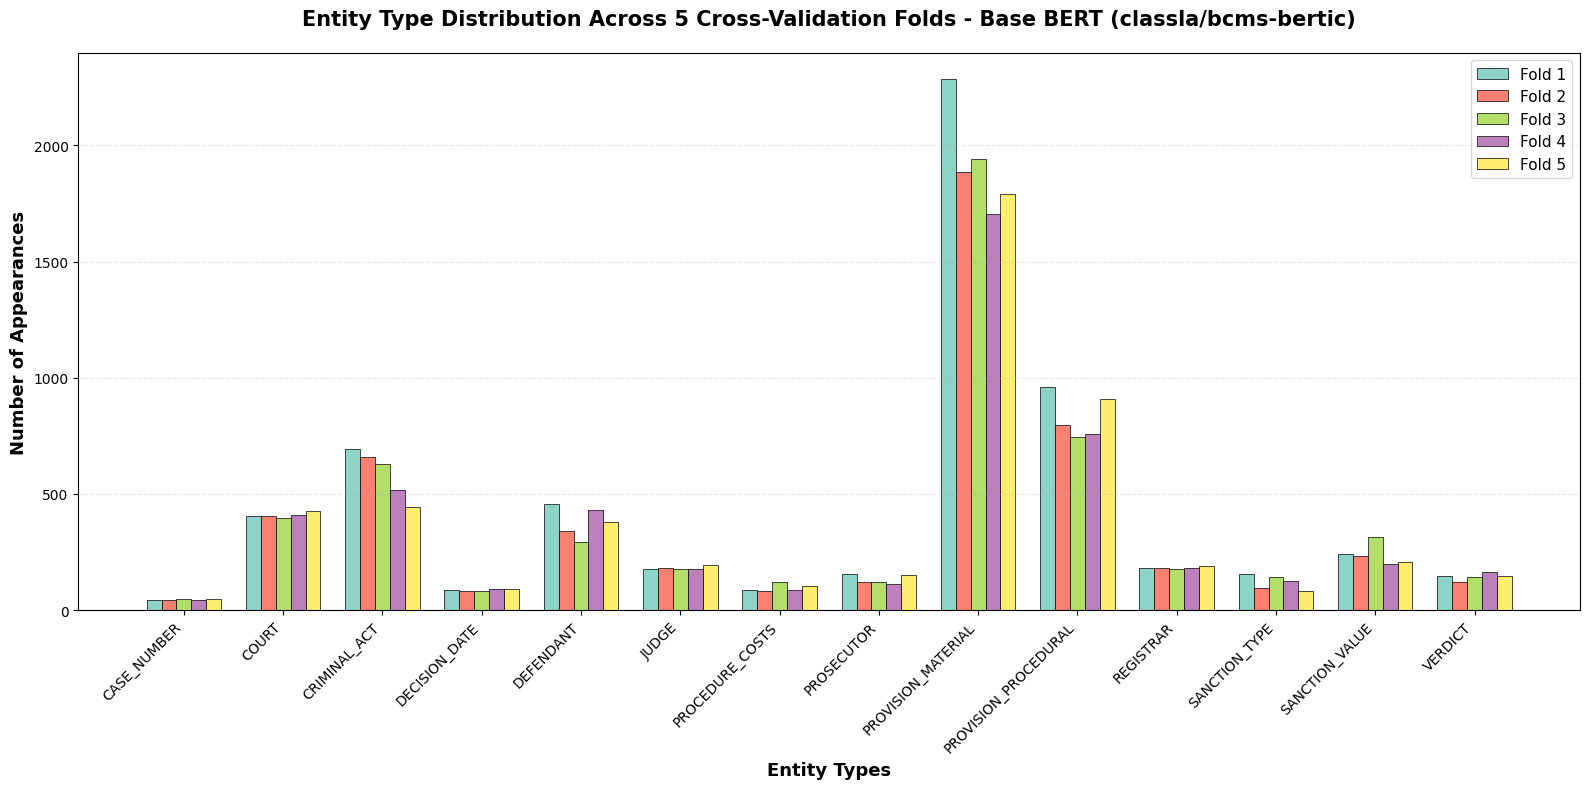

✅ Entity distribution across folds visualization displayed

📉 Plotting training and validation loss...

PLOTTING TRAINING AND VALIDATION LOSS ACROSS 5 FOLDS


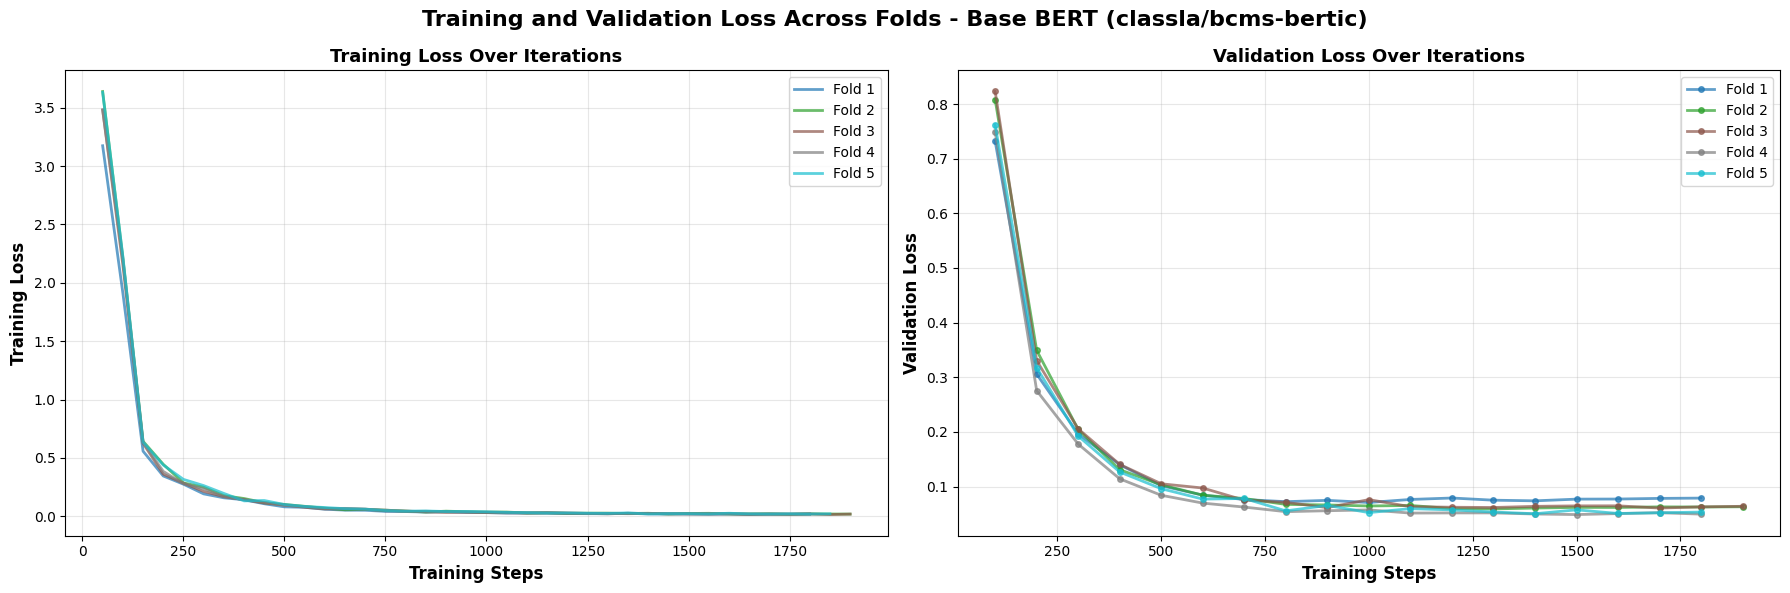

✅ Training and validation loss visualization displayed

📈 Plotting macro/micro-averaged metrics over iterations...

PLOTTING MACRO/MICRO-AVERAGED METRICS OVER ITERATIONS
📊 Aligning 18 evaluation points across 5 folds


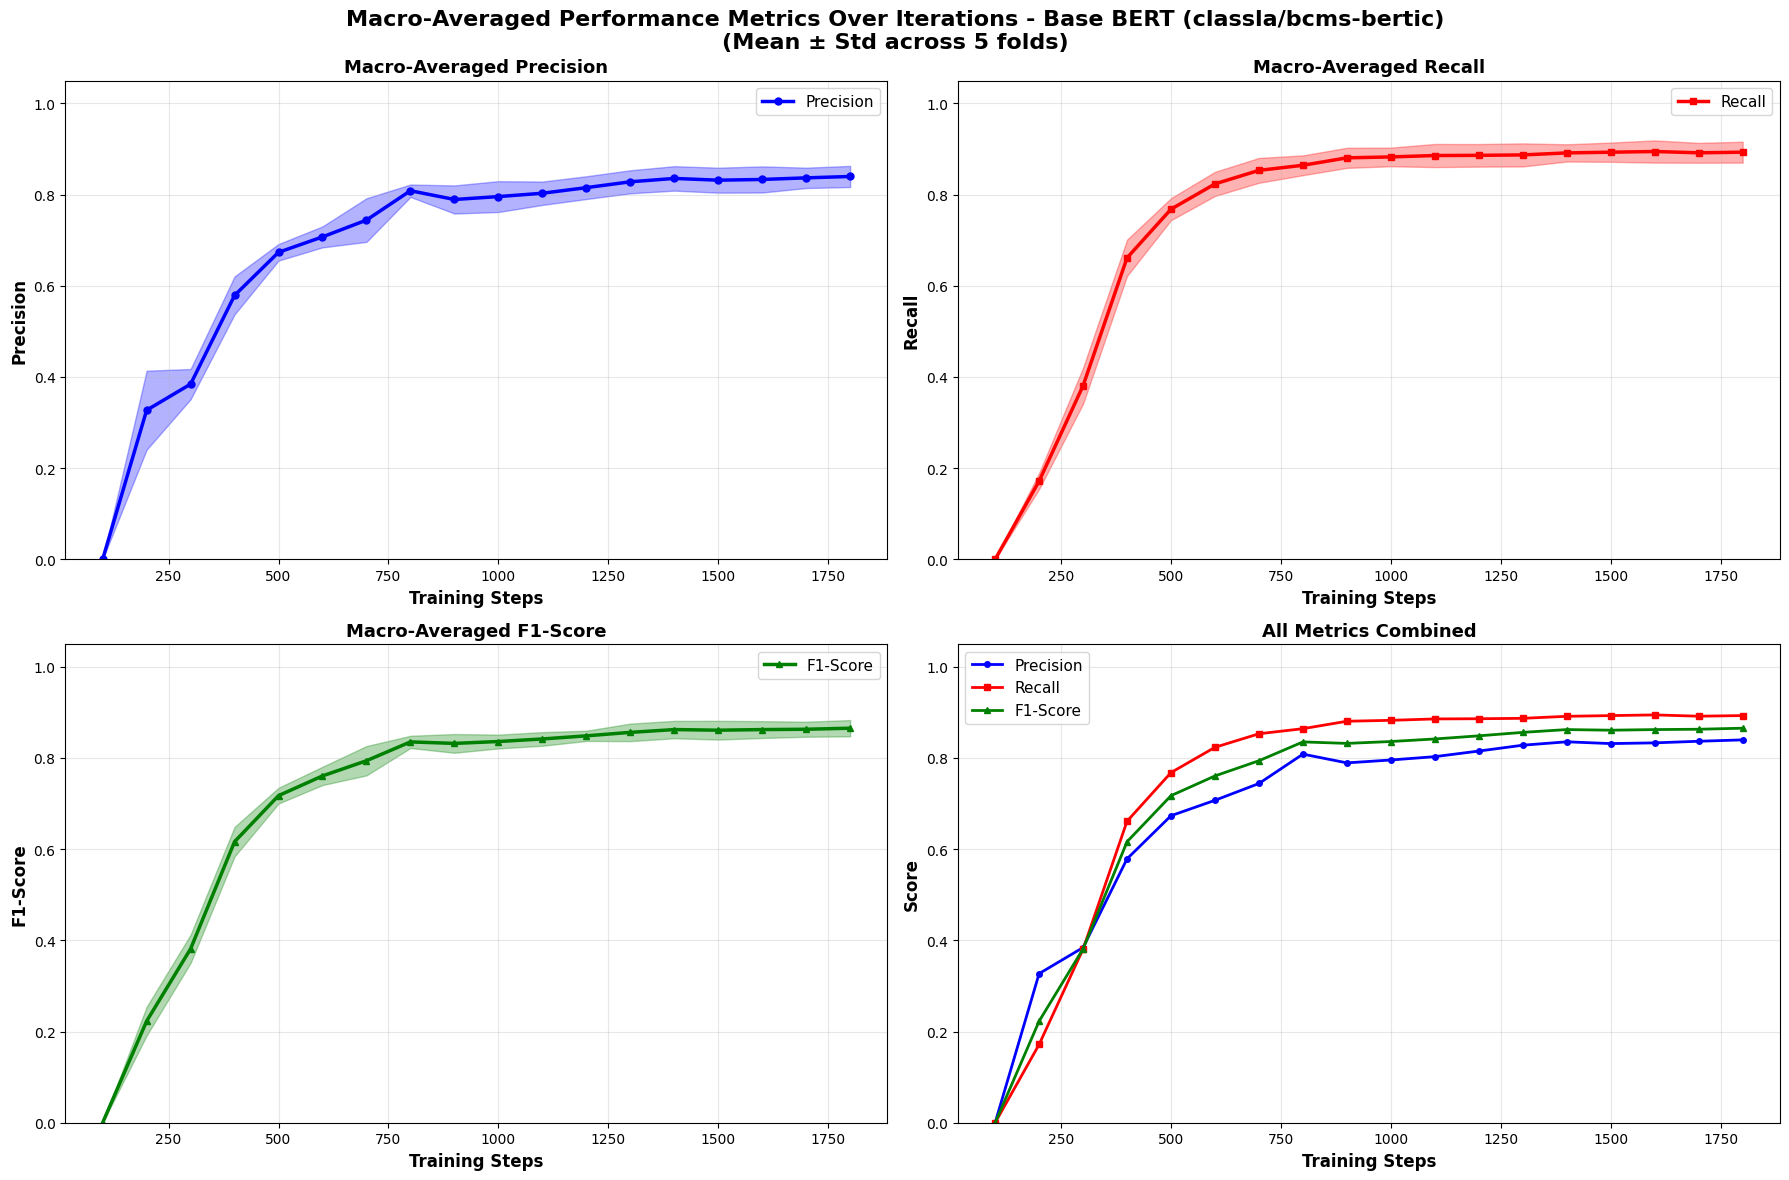

✅ Macro/micro-averaged metrics visualization displayed

📈 Aggregating training metrics...

AGGREGATING TRAINING METRICS ACROSS 5 FOLDS
📊 Aligning 18 evaluation points across 5 folds


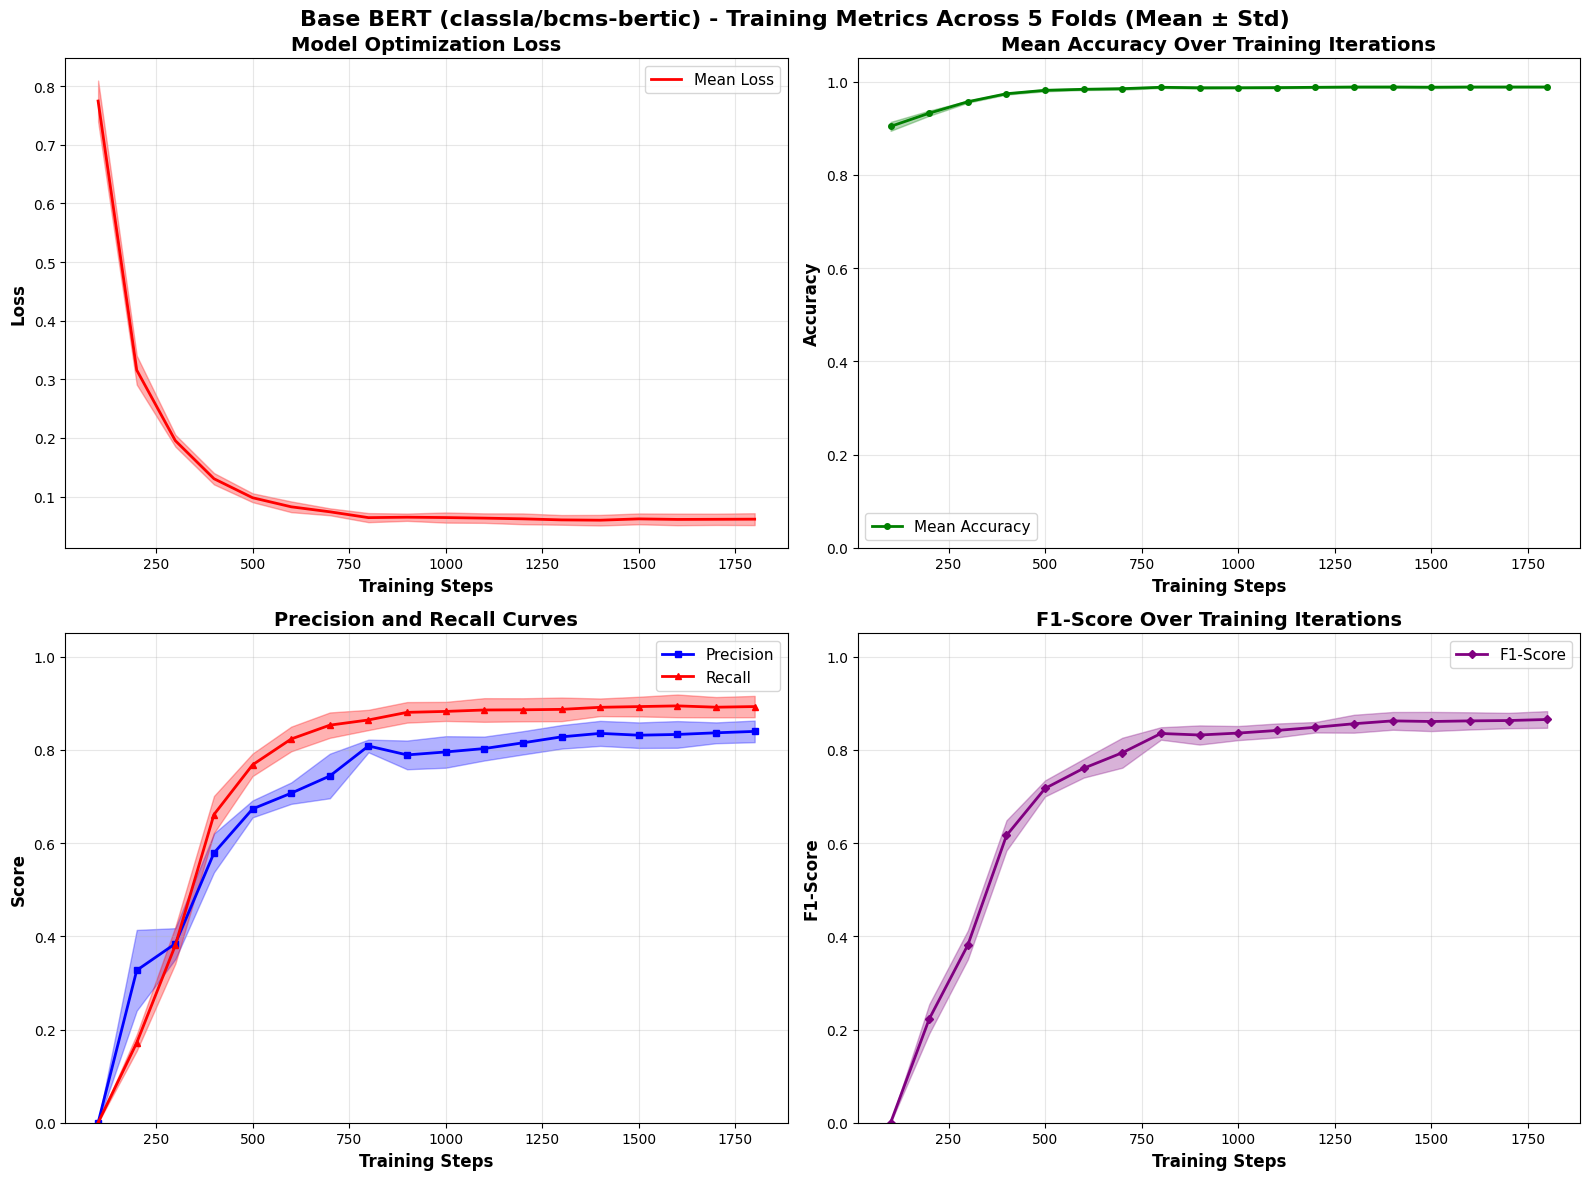

✅ Aggregate training metrics visualization displayed

📊 Aggregating per-class metrics...

AGGREGATING PER-CLASS METRICS ACROSS 5 FOLDS

Base BERT (classla/bcms-bertic) - Aggregated Classification Report (Mean ± Std)

Label                           Precision          Recall        F1-Score      Support
-------------------------------------------------------------------------------------
B-CASE_NUMBER               0.7203±0.0490   0.9189±0.0374   0.8060±0.0293         45±1
B-COURT                     0.9041±0.0494   0.9481±0.0321   0.9240±0.0217        123±6
B-CRIMINAL_ACT              0.9379±0.0218   0.9583±0.0195   0.9479±0.0178       466±40
B-DECISION_DATE             0.9130±0.0191   0.9513±0.0340   0.9314±0.0194        119±3
B-DEFENDANT                 0.7635±0.0611   0.8170±0.0692   0.7865±0.0440       693±88
B-JUDGE                     0.9635±0.0222   0.8928±0.0496   0.9261±0.0317        112±8
B-PROCEDURE_COSTS           0.8921±0.0683   0.9293±0.0366   0.9094±0.0482       131±22
B

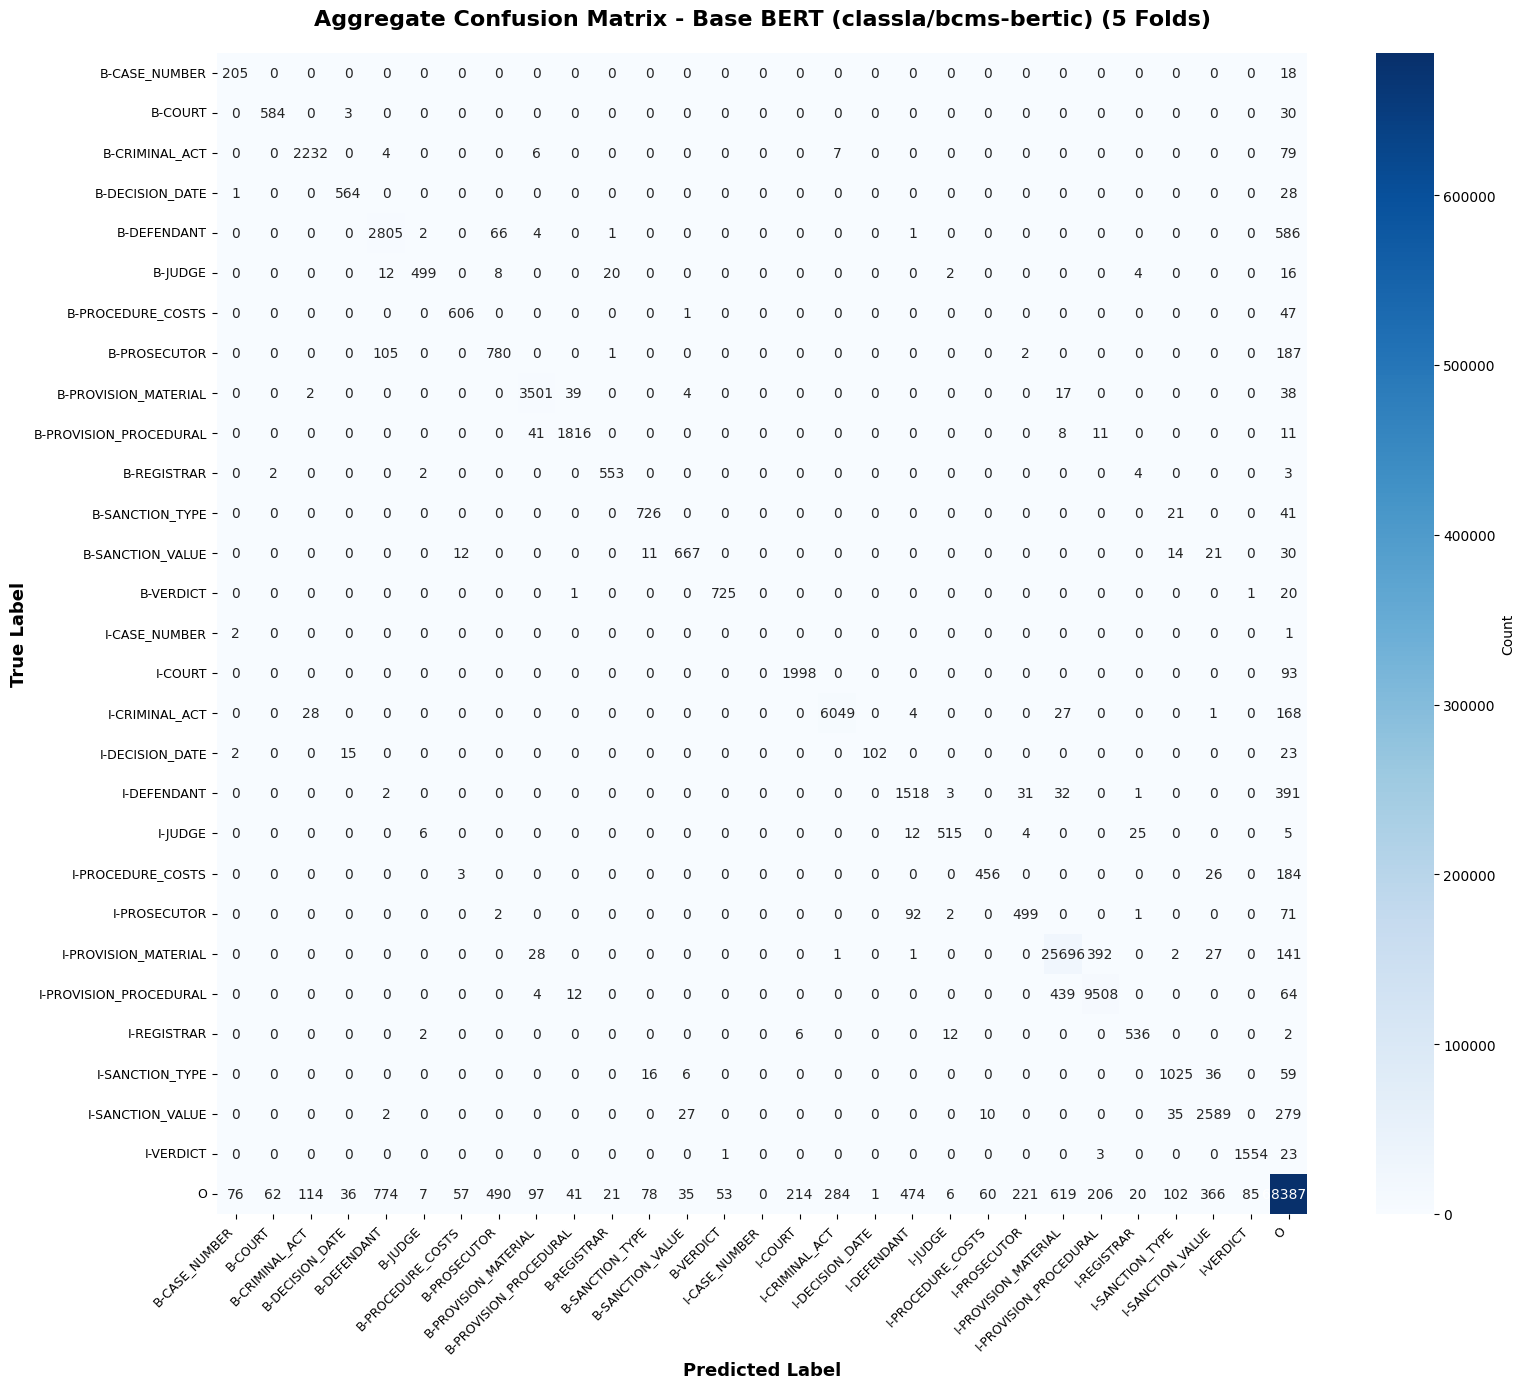

✅ Aggregate confusion matrix visualization displayed

📈 Aggregating F1 per class over iterations...

AGGREGATING F1 PER CLASS OVER ITERATIONS
⚠️  No per-class metrics found in training histories
ℹ️  This is normal if PerClassMetricsCallback didn't have access to model/eval_dataset during training
ℹ️  Per-class metrics are still available in the final classification report
ℹ️  Skipping F1 per class over iterations plot

✅ Aggregate report completed!

All visualizations displayed in notebook above.
Error in callback <bound method _WandbInit._pause_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7f1d282e1c10>> (for post_run_cell), with arguments args (<ExecutionResult object at 7f1d06658fd0, execution_count=17 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 7f1d3270cc90, raw_cell="# ================================================.." store_history=True silent=False shell_futures=True cell_id=b1e97248-9371-4dca-bc39-0fb24f8476d4> result=None>,),kwargs {}:


TypeError: _WandbInit._pause_backend() takes 1 positional argument but 2 were given

In [17]:
# ============================================================================
# GENERATE COMPREHENSIVE AGGREGATE REPORT
# ============================================================================

print(f"\n{'='*80}")
print(f"GENERATING AGGREGATE REPORT ACROSS ALL {N_FOLDS} FOLDS")
print(f"{'='*80}")

# Create aggregate report with all visualizations displayed in notebook
aggregate_report = create_aggregate_report_across_folds(
    fold_results=fold_results,
    model_name="Base BERT (classla/bcms-bertic)",
    display=True
)

## 10. K-Fold Results Analysis and Summary

In [18]:
# ============================================================================
# K-FOLD RESULTS SUMMARY
# ============================================================================

print(f"\n{'='*80}")
print(f"K-FOLD CROSS-VALIDATION RESULTS SUMMARY")
print(f"{'='*80}")

# Extract metrics from all folds
precisions = [result['precision'] for result in fold_results]
recalls = [result['recall'] for result in fold_results]
f1_scores = [result['f1'] for result in fold_results]
accuracies = [result['accuracy'] for result in fold_results]

# Calculate statistics
print(f"\n📊 PERFORMANCE METRICS ACROSS {N_FOLDS} FOLDS:")
print(f"{'='*50}")

print(f"\n🎯 PRECISION:")
print(f"  Mean: {np.mean(precisions):.4f} ± {np.std(precisions):.4f}")
print(f"  Min:  {np.min(precisions):.4f} (Fold {np.argmin(precisions) + 1})")
print(f"  Max:  {np.max(precisions):.4f} (Fold {np.argmax(precisions) + 1})")

print(f"\n🎯 RECALL:")
print(f"  Mean: {np.mean(recalls):.4f} ± {np.std(recalls):.4f}")
print(f"  Min:  {np.min(recalls):.4f} (Fold {np.argmin(recalls) + 1})")
print(f"  Max:  {np.max(recalls):.4f} (Fold {np.argmax(recalls) + 1})")

print(f"\n🎯 F1-SCORE:")
print(f"  Mean: {np.mean(f1_scores):.4f} ± {np.std(f1_scores):.4f}")
print(f"  Min:  {np.min(f1_scores):.4f} (Fold {np.argmin(f1_scores) + 1})")
print(f"  Max:  {np.max(f1_scores):.4f} (Fold {np.argmax(f1_scores) + 1})")

print(f"\n🎯 ACCURACY:")
print(f"  Mean: {np.mean(accuracies):.4f} ± {np.std(accuracies):.4f}")
print(f"  Min:  {np.min(accuracies):.4f} (Fold {np.argmin(accuracies) + 1})")
print(f"  Max:  {np.max(accuracies):.4f} (Fold {np.argmax(accuracies) + 1})")

# Individual fold results
print(f"\n📋 INDIVIDUAL FOLD RESULTS:")
print(f"{'='*50}")
for i, result in enumerate(fold_results, 1):
    print(f"Fold {i}: P={result['precision']:.4f}, R={result['recall']:.4f}, F1={result['f1']:.4f}, Acc={result['accuracy']:.4f}")

Error in callback <bound method _WandbInit._resume_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7f1d282e1c10>> (for pre_run_cell), with arguments args (<ExecutionInfo object at 7f1d066023d0, raw_cell="# ================================================.." store_history=True silent=False shell_futures=True cell_id=69f3c4ca-4134-4c12-98d8-87637bf62fa9>,),kwargs {}:


TypeError: _WandbInit._resume_backend() takes 1 positional argument but 2 were given


K-FOLD CROSS-VALIDATION RESULTS SUMMARY

📊 PERFORMANCE METRICS ACROSS 5 FOLDS:

🎯 PRECISION:
  Mean: 0.8314 ± 0.0274
  Min:  0.8009 (Fold 3)
  Max:  0.8745 (Fold 2)

🎯 RECALL:
  Mean: 0.8928 ± 0.0211
  Min:  0.8532 (Fold 1)
  Max:  0.9130 (Fold 4)

🎯 F1-SCORE:
  Mean: 0.8608 ± 0.0206
  Min:  0.8309 (Fold 1)
  Max:  0.8869 (Fold 2)

🎯 ACCURACY:
  Mean: 0.9881 ± 0.0020
  Min:  0.9851 (Fold 1)
  Max:  0.9912 (Fold 4)

📋 INDIVIDUAL FOLD RESULTS:
Fold 1: P=0.8098, R=0.8532, F1=0.8309, Acc=0.9851
Fold 2: P=0.8745, R=0.8996, F1=0.8869, Acc=0.9889
Fold 3: P=0.8009, R=0.9071, F1=0.8507, Acc=0.9877
Fold 4: P=0.8511, R=0.9130, F1=0.8810, Acc=0.9912
Fold 5: P=0.8208, R=0.8914, F1=0.8546, Acc=0.9877
Error in callback <bound method _WandbInit._pause_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7f1d282e1c10>> (for post_run_cell), with arguments args (<ExecutionResult object at 7f1d066f9d90, execution_count=18 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 7f1d0660

TypeError: _WandbInit._pause_backend() takes 1 positional argument but 2 were given

Error in callback <bound method _WandbInit._resume_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7f1d282e1c10>> (for pre_run_cell), with arguments args (<ExecutionInfo object at 7f1d10587bd0, raw_cell="# ================================================.." store_history=True silent=False shell_futures=True cell_id=ec39d665-d472-435b-bef0-12f5d7e00bcf>,),kwargs {}:


TypeError: _WandbInit._resume_backend() takes 1 positional argument but 2 were given

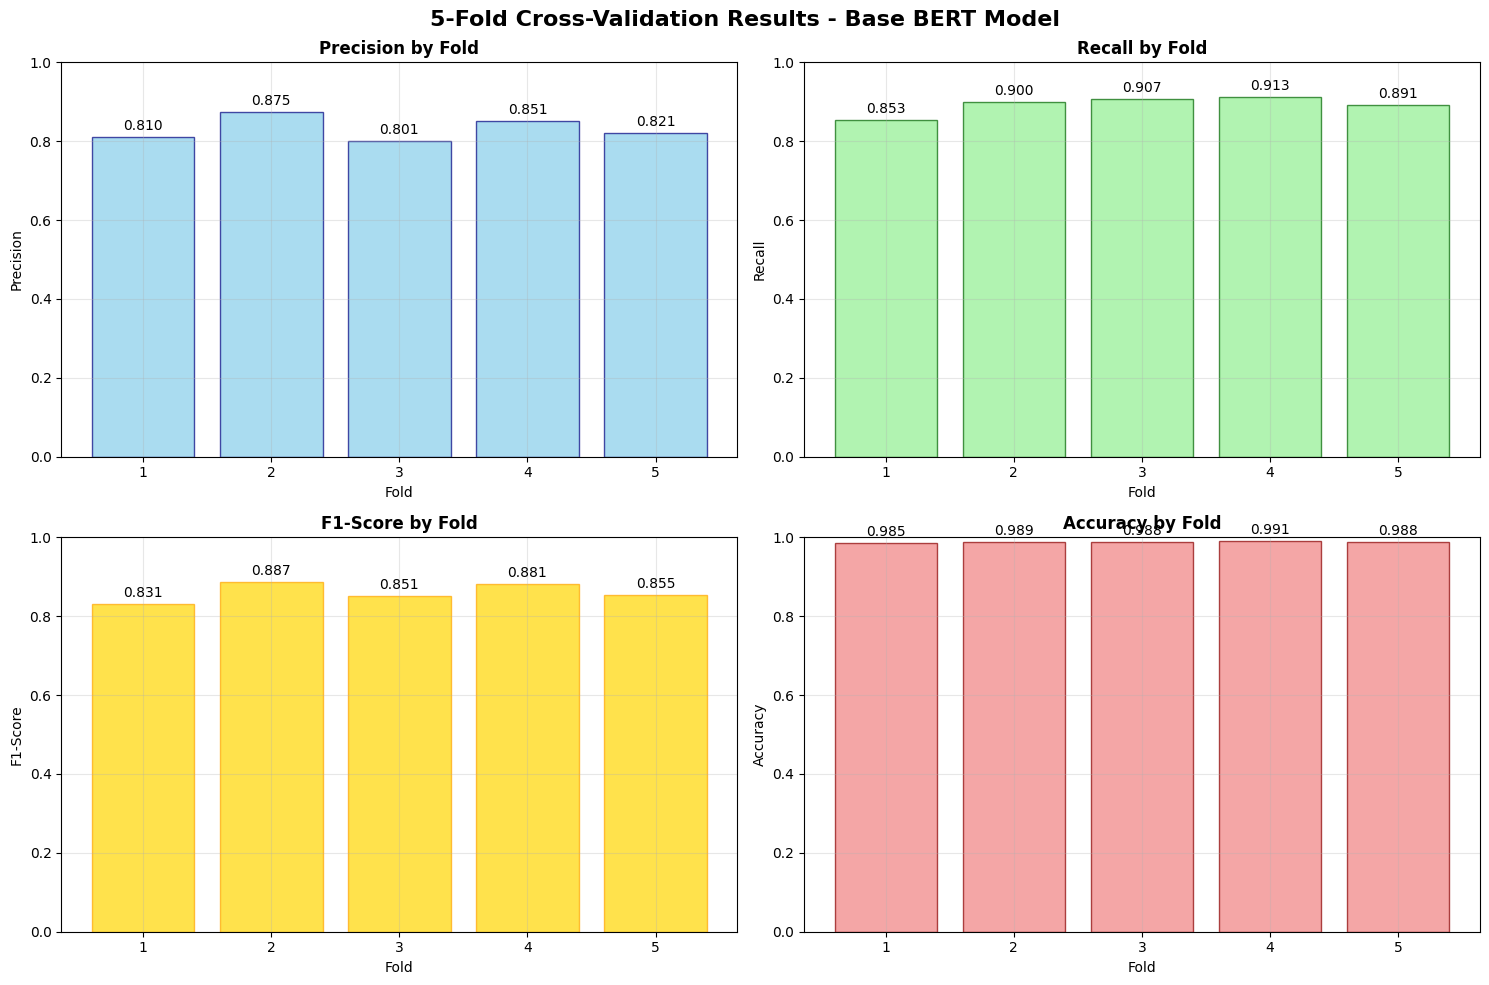

Error in callback <bound method _WandbInit._pause_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7f1d282e1c10>> (for post_run_cell), with arguments args (<ExecutionResult object at 7f1d517f79d0, execution_count=14 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 7f1d10587bd0, raw_cell="# ================================================.." store_history=True silent=False shell_futures=True cell_id=ec39d665-d472-435b-bef0-12f5d7e00bcf> result=None>,),kwargs {}:


TypeError: _WandbInit._pause_backend() takes 1 positional argument but 2 were given

In [14]:
# ============================================================================
# VISUALIZATION OF K-FOLD RESULTS
# ============================================================================

import matplotlib.pyplot as plt

# Create visualization of fold results
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle(f'{N_FOLDS}-Fold Cross-Validation Results - Base BERT Model', fontsize=16, fontweight='bold')

fold_numbers = list(range(1, N_FOLDS + 1))

# Precision plot
ax1.bar(fold_numbers, precisions, alpha=0.7, color='skyblue', edgecolor='navy')
ax1.set_title('Precision by Fold', fontweight='bold')
ax1.set_xlabel('Fold')
ax1.set_ylabel('Precision')
ax1.set_ylim(0, 1)
ax1.grid(True, alpha=0.3)
for i, v in enumerate(precisions):
    ax1.text(i+1, v+0.01, f'{v:.3f}', ha='center', va='bottom')

# Recall plot
ax2.bar(fold_numbers, recalls, alpha=0.7, color='lightgreen', edgecolor='darkgreen')
ax2.set_title('Recall by Fold', fontweight='bold')
ax2.set_xlabel('Fold')
ax2.set_ylabel('Recall')
ax2.set_ylim(0, 1)
ax2.grid(True, alpha=0.3)
for i, v in enumerate(recalls):
    ax2.text(i+1, v+0.01, f'{v:.3f}', ha='center', va='bottom')

# F1-Score plot
ax3.bar(fold_numbers, f1_scores, alpha=0.7, color='gold', edgecolor='orange')
ax3.set_title('F1-Score by Fold', fontweight='bold')
ax3.set_xlabel('Fold')
ax3.set_ylabel('F1-Score')
ax3.set_ylim(0, 1)
ax3.grid(True, alpha=0.3)
for i, v in enumerate(f1_scores):
    ax3.text(i+1, v+0.01, f'{v:.3f}', ha='center', va='bottom')

# Accuracy plot
ax4.bar(fold_numbers, accuracies, alpha=0.7, color='lightcoral', edgecolor='darkred')
ax4.set_title('Accuracy by Fold', fontweight='bold')
ax4.set_xlabel('Fold')
ax4.set_ylabel('Accuracy')
ax4.set_ylim(0, 1)
ax4.grid(True, alpha=0.3)
for i, v in enumerate(accuracies):
    ax4.text(i+1, v+0.01, f'{v:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

Error in callback <bound method _WandbInit._resume_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7f1d282e1c10>> (for pre_run_cell), with arguments args (<ExecutionInfo object at 7f1d105519d0, raw_cell="# Box plot for metric distribution
fig, ax = plt.s.." store_history=True silent=False shell_futures=True cell_id=643253d4-fa66-47c9-b8da-4c83d534a407>,),kwargs {}:


TypeError: _WandbInit._resume_backend() takes 1 positional argument but 2 were given

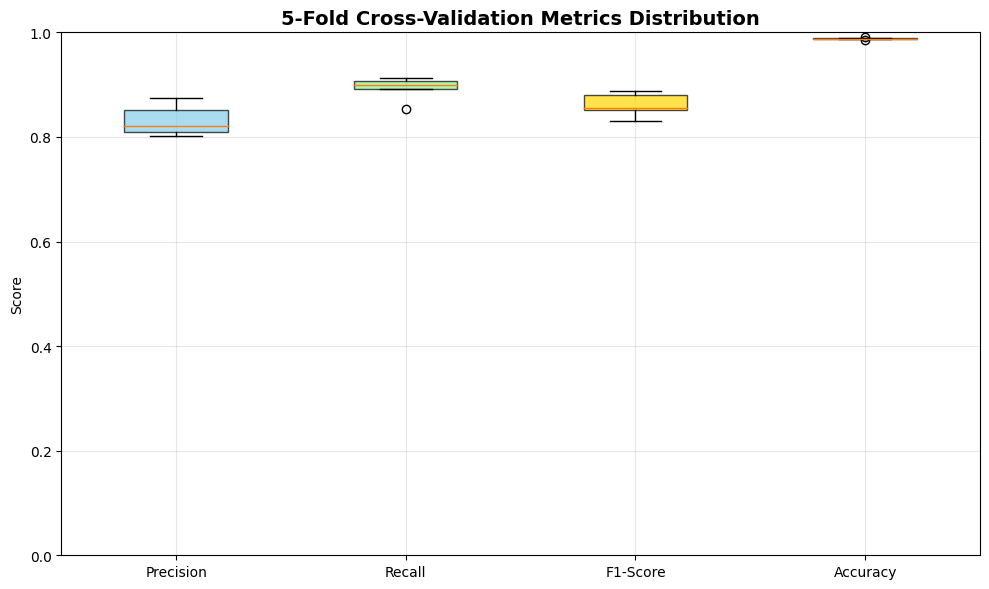

Error in callback <bound method _WandbInit._pause_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7f1d282e1c10>> (for post_run_cell), with arguments args (<ExecutionResult object at 7f1d068aff50, execution_count=15 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 7f1d105519d0, raw_cell="# Box plot for metric distribution
fig, ax = plt.s.." store_history=True silent=False shell_futures=True cell_id=643253d4-fa66-47c9-b8da-4c83d534a407> result=None>,),kwargs {}:


TypeError: _WandbInit._pause_backend() takes 1 positional argument but 2 were given

In [15]:
# Box plot for metric distribution
fig, ax = plt.subplots(figsize=(10, 6))
metrics_data = [precisions, recalls, f1_scores, accuracies]
labels = ['Precision', 'Recall', 'F1-Score', 'Accuracy']

box_plot = ax.boxplot(metrics_data, labels=labels, patch_artist=True)
colors = ['skyblue', 'lightgreen', 'gold', 'lightcoral']
for patch, color in zip(box_plot['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

ax.set_title(f'{N_FOLDS}-Fold Cross-Validation Metrics Distribution', fontsize=14, fontweight='bold')
ax.set_ylabel('Score')
ax.grid(True, alpha=0.3)
ax.set_ylim(0, 1)

plt.tight_layout()
plt.show()

## 10. Save Results and Final Summary

In [16]:
# ============================================================================
# SAVE RESULTS TO FILE
# ============================================================================

import json
import pandas as pd
from datetime import datetime

# Create results summary
results_summary = {
    'experiment_info': {
        'model_name': MODEL_NAME,
        'n_folds': N_FOLDS,
        'total_examples': len(prepared_examples),
        'timestamp': datetime.now().isoformat(),
        'device': str(device)
    },
    'overall_metrics': {
        'precision': {
            'mean': float(np.mean(precisions)),
            'std': float(np.std(precisions)),
            'min': float(np.min(precisions)),
            'max': float(np.max(precisions))
        },
        'recall': {
            'mean': float(np.mean(recalls)),
            'std': float(np.std(recalls)),
            'min': float(np.min(recalls)),
            'max': float(np.max(recalls))
        },
        'f1_score': {
            'mean': float(np.mean(f1_scores)),
            'std': float(np.std(f1_scores)),
            'min': float(np.min(f1_scores)),
            'max': float(np.max(f1_scores))
        },
        'accuracy': {
            'mean': float(np.mean(accuracies)),
            'std': float(np.std(accuracies)),
            'min': float(np.min(accuracies)),
            'max': float(np.max(accuracies))
        }
    },
    'fold_results': [
        {
            'fold': result['fold'],
            'precision': float(result['precision']),
            'recall': float(result['recall']),
            'f1': float(result['f1']),
            'accuracy': float(result['accuracy'])
        }
        for result in fold_results
    ]
}

# Save results to JSON
results_file = f"{OUTPUT_DIR}/5fold_cv_results.json"
with open(results_file, 'w', encoding='utf-8') as f:
    json.dump(results_summary, f, indent=2, ensure_ascii=False)

print(f"✅ Results saved to: {results_file}")

# Create CSV for easy analysis
df_results = pd.DataFrame([
    {
        'Fold': result['fold'],
        'Precision': result['precision'],
        'Recall': result['recall'],
        'F1-Score': result['f1'],
        'Accuracy': result['accuracy']
    }
    for result in fold_results
])

# Add summary row
summary_row = {
    'Fold': 'Mean ± Std',
    'Precision': f"{np.mean(precisions):.4f} ± {np.std(precisions):.4f}",
    'Recall': f"{np.mean(recalls):.4f} ± {np.std(recalls):.4f}",
    'F1-Score': f"{np.mean(f1_scores):.4f} ± {np.std(f1_scores):.4f}",
    'Accuracy': f"{np.mean(accuracies):.4f} ± {np.std(accuracies):.4f}"
}

df_results = pd.concat([df_results, pd.DataFrame([summary_row])], ignore_index=True)

csv_file = f"{OUTPUT_DIR}/5fold_cv_results.csv"
df_results.to_csv(csv_file, index=False)
print(f"✅ Results CSV saved to: {csv_file}")

# Display final summary table
print(f"\n📊 FINAL RESULTS TABLE:")
print(df_results.to_string(index=False))

Error in callback <bound method _WandbInit._resume_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7f1d282e1c10>> (for pre_run_cell), with arguments args (<ExecutionInfo object at 7f1d102d1290, raw_cell="# ================================================.." store_history=True silent=False shell_futures=True cell_id=c99b6783-8dff-4dc8-b3c8-66c8626119da>,),kwargs {}:


TypeError: _WandbInit._resume_backend() takes 1 positional argument but 2 were given

✅ Results saved to: /storage/models/bertic_base_5fold_cv/5fold_cv_results.json
✅ Results CSV saved to: /storage/models/bertic_base_5fold_cv/5fold_cv_results.csv

📊 FINAL RESULTS TABLE:
      Fold       Precision          Recall        F1-Score        Accuracy
         1        0.809829        0.853177        0.830938        0.985064
         2        0.874548        0.899571        0.886883        0.988881
         3        0.800932        0.907065        0.850701        0.987705
         4        0.851116        0.912993        0.880969        0.991188
         5        0.820817        0.891352        0.854631        0.987688
Mean ± Std 0.8314 ± 0.0274 0.8928 ± 0.0211 0.8608 ± 0.0206 0.9881 ± 0.0020
Error in callback <bound method _WandbInit._pause_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7f1d282e1c10>> (for post_run_cell), with arguments args (<ExecutionResult object at 7f1d13fc1e90, execution_count=16 error_before_exec=None error_in_exec=None info=<ExecutionInfo objec

TypeError: _WandbInit._pause_backend() takes 1 positional argument but 2 were given